In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [ ]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/src/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


#### 2. Sample the `graph`

In [3]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### 3. generate reaction statistics

In [4]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2 + 1 SO2 = 1 O2 + 1 H2S               336
1 H2O + 1 SO2 = 1 H2SO3                   301
2 H2 + 1 O2 = 2 H2O                       288
3 H2 + 1 SO2 = 2 H2O + 1 H2S              198
3 O2 + 2 H2S = 2 H2O + 2 SO2              174
1 H2O + 1 NO2 + 1 NO = 2 HNO2             164
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2             91
1 H2O + 1 SO2 + 1 NO2 = 1 H2SO4 + 1 NO     91
8 O2 + 1 S8 = 8 SO2                        87
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2            64
dtype: int64

#### 4. generate mean concentrations and differences

In [5]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

        initial   mean  diff   sem   std    var
H2S        10.0   5.10 -4.90  0.09  4.76  22.62
O2         10.0   6.23 -3.77  0.11  5.74  32.92
NO2        10.0   6.56 -3.44  0.09  4.75  22.52
H2O        30.0  30.06  0.06  0.10  5.25  27.57
NH3         0.0   0.06  0.06  0.01  0.58   0.34
S8          0.0   0.10  0.10  0.01  0.36   0.13
NOHSO4      0.0   0.21  0.21  0.02  0.99   0.98
H2SO3       0.0   0.28  0.28  0.03  1.63   2.67
HNO3        0.0   0.49  0.49  0.03  1.55   2.41
N2          0.0   0.50  0.50  0.03  1.45   2.09
HNO2        0.0   0.52  0.52  0.03  1.74   3.02
NO          0.0   1.08  1.08  0.06  3.01   9.03
H2SO4       0.0   1.24  1.24  0.07  3.33  11.11
SO2        10.0  11.57  1.57  0.12  6.14  37.67
H2          0.0   2.22  2.22  0.08  4.08  16.68


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_94219/949321809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name='RdBu')  # or any other colormap


<Axes: >

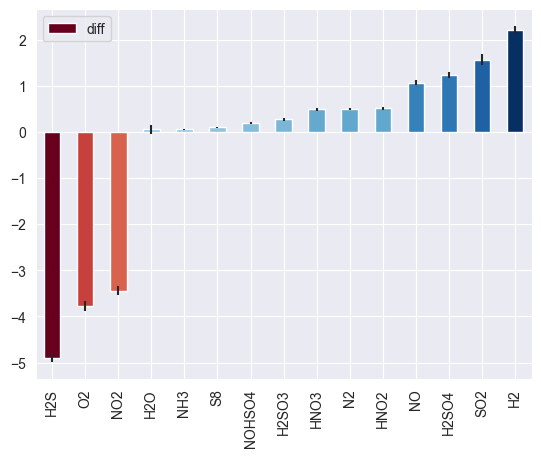

In [6]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [ ]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white'}
g = analysis.result_to_pyvis(data,head=10)
g.save_graph(name="example_pyvis_graph.html")